In [ ]:
#################################### This script creates fig. 8 of the article ###############################

In [2]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools as it
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.pyplot import figure
import matplotlib.transforms as mtransforms
from matplotlib.ticker import FormatStrFormatter
import scipy 
from statsmodels.regression.linear_model import OLSResults
import csv

In [3]:
# Import the raw UAV data from a CSV file
pathToFile = 'F:/Redaction/Bernadouze/Figures/RAW_UAV_DATA_Indices.csv'
rawData = pd.read_csv(pathToFile,sep=',')
UAVData = pd.DataFrame(rawData)
UAVData.head()

,Plot,Season,GEP (gCO2.m².hour-1),ER (gCO2.m².hour-1),NEE (gCO2.m².hour-1),B,G,R,RE,NIR,...,GLI,GNDVI,LCI,NDRE,NDVI,OSAVI,RCC,RVI,SIPI,TVI
0,P1,May,-1.86,1.30,-0.56,0.5,0.6,1.000000,0.928571,0.761905,...,-0.265873,-0.022281,-0.975119,-1.000000,-0.596716,0.245283,0.806763,-0.839695,0.890909,-0.576983
1,P3,May,-1.47,1.28,-0.19,0.5,0.6,0.333333,0.571429,0.619048,...,0.269841,-0.283322,-0.332242,-0.375955,-0.038493,0.462713,-0.022222,-0.515812,-0.054545,-0.008914
2,P4,May,-1.25,0.89,-0.36,0.5,0.8,0.555556,0.785714,0.714286,...,0.309524,-0.496021,-0.672967,-0.740397,-0.193893,0.421384,0.111111,-0.622137,0.223529,-0.165119
3,P5,May,-1.84,1.19,-0.65,0.5,0.2,-0.111111,0.071429,0.333333,...,0.159420,0.035492,0.460693,0.535150,0.252691,0.479245,-0.388889,-0.267176,-0.641379,0.279954
4,P6,May,-1.27,0.96,-0.31,1.0,0.8,0.777778,0.500000,0.476190,...,-0.028945,-1.000000,-0.650263,-0.585061,-0.694656,0.118077,0.222222,-0.882952,0.485714,-0.678701


In [3]:
# Resolve colinearity issue by eliminating colinear explanatory variables

UAVX = UAVData[{'PAR','DOY','TEMP', # meteo
             'B','G','R','RE','NIR', # bands
             'BCC','BRI','BWDRVI','CIgreen','CVI','EVI','EVI2','GARI','GCC','GLI','GNDVI','LCI','NDRE','NDVI','OSAVI','RCC','RVI','SIPI','TVI'}] # VIs

def calculate_vif_(X, thresh=5.0):
    X = X.assign(const=1)  # faster than add_constant from statsmodels
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]  # don't let the constant be removed in the loop.
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +'\' at index: ' + str(maxloc) + ' with VIF =' + str(max(vif)))
            del variables[maxloc]
            dropped = True
            print('Remaining variables:', X.columns[variables[:-1]])
    return 

calculate_vif_(UAVX)

C:\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


dropping 'BCC' at index: 0 with VIF =inf
Remaining variables: Index(['DOY', 'GLI', 'GNDVI', 'G', 'EVI', 'GCC', 'EVI2', 'GARI', 'R', 'BWDRVI',
       'LCI', 'B', 'NIR', 'SIPI', 'RVI', 'PAR', 'RE', 'CIgreen', 'CVI', 'BRI',
       'TVI', 'NDRE', 'TEMP', 'RCC', 'NDVI', 'OSAVI'],
      dtype='object')
dropping 'NDVI' at index: 24 with VIF =10149842.258906439
Remaining variables: Index(['DOY', 'GLI', 'GNDVI', 'G', 'EVI', 'GCC', 'EVI2', 'GARI', 'R', 'BWDRVI',
       'LCI', 'B', 'NIR', 'SIPI', 'RVI', 'PAR', 'RE', 'CIgreen', 'CVI', 'BRI',
       'TVI', 'NDRE', 'TEMP', 'RCC', 'OSAVI'],
      dtype='object')
dropping 'EVI2' at index: 6 with VIF =830898.4406166737
Remaining variables: Index(['DOY', 'GLI', 'GNDVI', 'G', 'EVI', 'GCC', 'GARI', 'R', 'BWDRVI', 'LCI',
       'B', 'NIR', 'SIPI', 'RVI', 'PAR', 'RE', 'CIgreen', 'CVI', 'BRI', 'TVI',
       'NDRE', 'TEMP', 'RCC', 'OSAVI'],
      dtype='object')
dropping 'GLI' at index: 1 with VIF =315067.1978694766
Remaining variables: Index(['DOY', 'GNDVI',

In [16]:
# Test models: each variable combinaison over 100 train/test splits
results_UAV = pd.DataFrame(columns=['VarToPred', 'SplitId', 'NbOfExpVar', 'ExpVar','R','RMSE','AIC', 'Model']) # Put results in a dataframe
FeatureOfImportance = pd.DataFrame() # Put coef in a dataframe for feature importance analysis
c = 0

predVar = ['NEE (gCO2.m².hour-1)', 'ER (gCO2.m².hour-1)', 'GEP (gCO2.m².hour-1)']

for p in predVar: # Loop by variable to predict
    y = UAVData[p]
    X = UAVData[{'NDRE', 'TEMP', 'BWDRVI', 'NIR', 'CVI', 'PAR', 'BRI'}]
    for i in range(1,len(X.columns)+1): # Loop by the number of explanatory variables (X)
        SelectedFeatureNames = list(combinations(X.columns,i)) # List all combinations
        for elem in SelectedFeatureNames:
            for SplitNb in range(100): # Split the dataset in train and test dataset
                c = c+1
                train, test = train_test_split(UAVData, test_size=0.4)
                X_train = train.loc[:,elem]
                y_train = train.loc[:,p]
                X_test = test.loc[:,elem]
                y_test = test.loc[:,p]
                # Fit a model with train dataset
                model = sm.OLS(y_train,sm.add_constant(X_train,has_constant='add')).fit()
                # Make prediction on the test dataset
                ypred = model.predict(sm.add_constant(X_test,has_constant='add'))
                AIC = model.aic
                R = np.corrcoef(y_test, ypred)
                RMSE = rmse(y_test, ypred)
                Parameters = model.params[1:]
                
                # Store results for evauating feature importance
                
                Parameters['VarToPred'] = p
                Parameters['SplitId'] = SplitNb
                Parameters['NbOfExpVar'] = i
                Parameters['ExpVar'] = elem
                Parameters['R'] = abs(R[0,1])
                Parameters['RMSE'] = RMSE
                Parameters['AIC'] = AIC
                Parameters['r2'] = model.rsquared
                Parameters['Model'] = model
                
                FeatureOfImportance = FeatureOfImportance.append(Parameters,ignore_index=True)
                
                # Write it in the dataframe
                results_UAV.loc[c, 'VarToPred'] = p
                results_UAV.loc[c, 'SplitId'] = SplitNb
                results_UAV.loc[c, 'NbOfExpVar'] = i
                results_UAV.at[c, 'ExpVar'] = elem
                results_UAV.loc[c, 'R'] = R[0,1]
                results_UAV.loc[c, 'RMSE'] = RMSE
                results_UAV.loc[c, 'AIC'] = AIC
                results_UAV.loc[c, 'Model'] = model
                
# Save to dbf
FeatureOfImportance.to_csv('F:/Redaction/Bernadouze/Figures/ModelsUAV_FeatureImportance.csv',index=True)
results_UAV.to_csv('F:/Redaction/Bernadouze/Figures/ModelsUAV.csv',index=False)
results_UAV

,VarToPred,SplitId,NbOfExpVar,ExpVar,R,RMSE,AIC,Model
1,NEE (gCO2.m².hour-1),0,1,"(PAR,)",0.314847,0.292635,14.823525,<statsmodels.regression.linear_model.Regressio...
2,NEE (gCO2.m².hour-1),1,1,"(PAR,)",0.331721,0.38796,2.285155,<statsmodels.regression.linear_model.Regressio...
3,NEE (gCO2.m².hour-1),2,1,"(PAR,)",0.059892,0.367238,6.125457,<statsmodels.regression.linear_model.Regressio...
4,NEE (gCO2.m².hour-1),3,1,"(PAR,)",0.467706,0.296326,15.165044,<statsmodels.regression.linear_model.Regressio...
5,NEE (gCO2.m².hour-1),4,1,"(PAR,)",0.363922,0.252422,18.454961,<statsmodels.regression.linear_model.Regressio...
...,...,...,...,...,...,...,...,...
38096,GEP (gCO2.m².hour-1),95,7,"(PAR, BWDRVI, NDRE, TEMP, BRI, CVI, NIR)",0.523699,0.410845,37.052602,<statsmodels.regression.linear_model.Regressio...
38097,GEP (gCO2.m².hour-1),96,7,"(PAR, BWDRVI, NDRE, TEMP, BRI, CVI, NIR)",0.786128,0.396942,40.613916,<statsmodels.regression.linear_model.Regressio...
38098,GEP (gCO2.m².hour-1),97,7,"(PAR, BWDRVI, NDRE, TEMP, BRI, CVI, NIR)",0.596987,0.644583,24.227285,<statsmodels.regression.linear_model.Regressio...
38099,GEP (gCO2.m².hour-1),98,7,"(PAR, BWDRVI, NDRE, TEMP, BRI, CVI, NIR)",0.860769,0.403865,42.674964,<statsmodels.regression.linear_model.Regressio...


In [4]:
# Read saved results
UAVData = pd.DataFrame(pd.read_csv('F:/Redaction/Bernadouze/Figures/RAW_UAV_DATA_Indices.csv',sep=','))
results_UAV = pd.DataFrame(pd.read_csv('F:/Redaction/Bernadouze/Figures/ModelsUAV.csv',sep=','))

In [5]:
# Filter the 10 best models based on Mean R
results_UAV['R'] = results_UAV['R'].abs()

# NEE
FeatureImportance_NEEgroup = results_UAV[results_UAV['VarToPred']=='NEE (gCO2.m².hour-1)']
FeatureImportance_NEEmean = FeatureImportance_NEEgroup.groupby(['ExpVar']).mean().sort_values(by=['R'],ascending=False)
FeatureImportance_NEEBestVars = FeatureImportance_NEEmean.head(10)
print('UAV Best variable combinaison for NEE: ',FeatureImportance_NEEBestVars['R'])

#ER
FeatureImportance_ERgroup = results_UAV[results_UAV['VarToPred']=='ER (gCO2.m².hour-1)']
FeatureImportance_ERmean = FeatureImportance_ERgroup.groupby(['ExpVar']).mean().sort_values(by=['R'],ascending=False)
FeatureImportance_ERBestVars = FeatureImportance_ERmean.head(10)
print('UAV Best variable combinaison for ER: ',FeatureImportance_ERBestVars['R'])

# GEP
FeatureImportance_GEPgroup = results_UAV[results_UAV['VarToPred']=='GEP (gCO2.m².hour-1)']
FeatureImportance_GEPmean = FeatureImportance_GEPgroup.groupby(['ExpVar']).mean().sort_values(by=['R'],ascending=False)
FeatureImportance_GEPBestVars = FeatureImportance_GEPmean.head(10)
print('UAV Best variable combinaison for GEP: ',FeatureImportance_GEPBestVars['R'])

UAV Best variable combinaison for NEE:  ExpVar
('BWDRVI', 'NDRE', 'TEMP')                         0.588379
('BWDRVI', 'NDRE', 'TEMP', 'NIR')                  0.553178
('PAR', 'BWDRVI', 'NDRE', 'TEMP')                  0.553054
('BWDRVI', 'NDRE', 'TEMP', 'CVI')                  0.549831
('BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR')           0.541428
('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'NIR')           0.513320
('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI')           0.512373
('PAR', 'BWDRVI', 'TEMP', 'NIR')                   0.496907
('BWDRVI', 'TEMP', 'NIR')                          0.496219
('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR')    0.493666
Name: R, dtype: float64
UAV Best variable combinaison for ER:  ExpVar
('PAR', 'BWDRVI', 'TEMP', 'NIR')                   0.749231
('PAR', 'BWDRVI', 'TEMP', 'CVI')                   0.748714
('PAR', 'BWDRVI', 'TEMP')                          0.745249
('PAR', 'BWDRVI', 'TEMP', 'CVI', 'NIR')            0.729039
('PAR', 'TEMP')                            

In [6]:
# Find best model based on Mean R
results_UAV['R'] = results_UAV['R'].abs()

# NEE
group = results_UAV[results_UAV['VarToPred']=='NEE (gCO2.m².hour-1)']
meanByExpVar = group.groupby(['ExpVar']).mean().reset_index().drop(columns=['SplitId']).rename(columns={"R": "Mean R", "RMSE": "Mean RMSE", "AIC":"Mean AIC"})
stdByExpVar = group.groupby(['ExpVar']).std().reset_index().drop(columns=['SplitId','NbOfExpVar','ExpVar']).rename(columns={"R": "Std R", "RMSE": "Std RMSE", "AIC":"Std AIC"})
UAV_NEE_BestModels = pd.concat([meanByExpVar, stdByExpVar], axis=1, join='inner').sort_values(by='Mean R',ascending=False)

# ER
group = results_UAV[results_UAV['VarToPred']=='ER (gCO2.m².hour-1)']
meanByExpVar = group.groupby(['ExpVar']).mean().reset_index().drop(columns=['SplitId']).rename(columns={"R": "Mean R", "RMSE": "Mean RMSE", "AIC":"Mean AIC"})
stdByExpVar = group.groupby(['ExpVar']).std().reset_index().drop(columns=['SplitId','NbOfExpVar','ExpVar']).rename(columns={"R": "Std R", "RMSE": "Std RMSE", "AIC":"Std AIC"})
UAV_ER_BestModels = pd.concat([meanByExpVar, stdByExpVar], axis=1, join='inner').sort_values(by='Mean R',ascending=False)

# GEP
group = results_UAV[results_UAV['VarToPred']=='GEP (gCO2.m².hour-1)']
meanByExpVar = group.groupby(['ExpVar']).mean().reset_index().drop(columns=['SplitId']).rename(columns={"R": "Mean R", "RMSE": "Mean RMSE", "AIC":"Mean AIC"})
stdByExpVar = group.groupby(['ExpVar']).std().reset_index().drop(columns=['SplitId','NbOfExpVar','ExpVar']).rename(columns={"R": "Std R", "RMSE": "Std RMSE", "AIC":"Std AIC"})
UAV_GEP_BestModels = pd.concat([meanByExpVar, stdByExpVar], axis=1, join='inner').sort_values(by='Mean R',ascending=False)

# NEE
UAV_NEEgroup = results_UAV[results_UAV['VarToPred']=='NEE (gCO2.m².hour-1)']
UAV_NEEmean = UAV_NEEgroup.groupby(['ExpVar']).mean().sort_values(by=['R'],ascending=False)
UAV_NEEstd = UAV_NEEgroup.groupby(['ExpVar']).std().sort_values(by=['R'],ascending=False)
UAV_NEEBestVars = UAV_NEEmean.index[0]
print('UAV Best variable combinaison for NEE: ',UAV_NEEBestVars)
UAV_NEENbVar = UAV_NEEmean.iloc[0,1]
print('N = ',UAV_NEENbVar)
UAV_NEEMeanR = UAV_NEEmean.iloc[0,2]
UAV_NEEStdR = UAV_NEEstd.iloc[0,2]
print('R = %.2f' % UAV_NEEMeanR) #, '± %.0f'% UAV_NEEStdR
UAV_NEEMeanRMSE = UAV_NEEmean.iloc[0,3]
UAV_NEEStdRMSE = UAV_NEEstd.iloc[0,3]
print('RMSE = %.1f' % UAV_NEEMeanRMSE) #,'± %.0f' % UAV_NEEStdRMSE
UAV_NEEMeanAIC = UAV_NEEmean.iloc[0,4]
UAV_NEEStdAIC = UAV_NEEstd.iloc[0,4]
print('AIC = %.0f'% UAV_NEEMeanAIC,'± %.0f ' % UAV_NEEStdAIC)

# ER
UAV_ERgroup = results_UAV[results_UAV['VarToPred']=='ER (gCO2.m².hour-1)']
UAV_ERmean = UAV_ERgroup.groupby(['ExpVar']).mean().sort_values(by=['R'],ascending=False)
UAV_ERstd = UAV_ERgroup.groupby(['ExpVar']).std().sort_values(by=['R'],ascending=False)
UAV_ERBestVars = UAV_ERmean.index[0]
print('UAV Best variable combinaison for ER: ',UAV_ERBestVars)
UAV_ERNbVar = UAV_ERmean.iloc[0,1]
print('N = ',UAV_ERNbVar)
UAV_ERMeanR = UAV_ERmean.iloc[0,2]
UAV_ERStdR = UAV_ERstd.iloc[0,2]
print('R = %.2f' % UAV_ERMeanR) #
UAV_ERMeanRMSE = UAV_ERmean.iloc[0,3]
UAV_ERStdRMSE = UAV_ERstd.iloc[0,3]
print('RMSE = %.1f' % UAV_ERMeanRMSE) #,'± %.0f' % UAV_ERStdRMSE
UAV_ERMeanAIC = UAV_ERmean.iloc[0,4]
UAV_ERStdAIC = UAV_ERstd.iloc[0,4]
print('AIC = %.0f'% UAV_ERMeanAIC,'± %.0f ' % UAV_ERStdAIC)

# GEP
UAV_GEPgroup = results_UAV[results_UAV['VarToPred']=='GEP (gCO2.m².hour-1)']
UAV_GEPmean = UAV_GEPgroup.groupby(['ExpVar']).mean().sort_values(by=['R'],ascending=False)
UAV_GEPstd = UAV_GEPgroup.groupby(['ExpVar']).std().sort_values(by=['R'],ascending=False)
UAV_GEPBestVars = UAV_GEPmean.index[0]
print('UAV Best variable combinaison for GEP: ',UAV_GEPBestVars)
UAV_GEPNbVar = UAV_GEPmean.iloc[0,1]
print('N = ',UAV_GEPNbVar)
UAV_GEPMeanR = UAV_GEPmean.iloc[0,2]
UAV_GEPStdR = UAV_GEPstd.iloc[0,2]
print('R = %.2f' % UAV_GEPMeanR) #, '± %.0f'% UAV_GEPStdR
UAV_GEPMeanRMSE = UAV_GEPmean.iloc[0,3]
UAV_GEPStdRMSE = UAV_GEPstd.iloc[0,3]
print('RMSE = %.1f' % UAV_GEPMeanRMSE) #,'± %.0f' % UAV_GEPStdRMSE
UAV_GEPMeanAIC = UAV_GEPmean.iloc[0,4]
UAV_GEPStdAIC = UAV_GEPstd.iloc[0,4]
print('AIC = %.0f'% UAV_GEPMeanAIC,'± %.0f ' % UAV_GEPStdAIC)

UAV Best variable combinaison for NEE:  ('BWDRVI', 'NDRE', 'TEMP')
N =  3.0
R = 0.59
RMSE = 0.3
AIC = 5 ± 6 
UAV Best variable combinaison for ER:  ('PAR', 'BWDRVI', 'TEMP', 'NIR')
N =  4.0
R = 0.75
RMSE = 0.4
AIC = 16 ± 9 
UAV Best variable combinaison for GEP:  ('PAR', 'NDRE', 'TEMP', 'CVI')
N =  4.0
R = 0.70
RMSE = 0.4
AIC = 29 ± 9 


In [14]:
# Save best model formulas for figure

# Import the raw data from a CSV files
rawData = pd.read_csv('F:/Redaction/Bernadouze/Figures/RAW_UAV_DATA_Indices.csv',sep=',')
UAV_Data = pd.DataFrame(rawData)

# UAV
# NEE
UAV_X = UAV_Data[{'BWDRVI', 'NDRE', 'TEMP'}]
UAV_NEE = UAV_Data['NEE (gCO2.m².hour-1)']
UAV_NEE_model = sm.OLS(UAV_NEE,sm.add_constant(UAV_X,has_constant='add')).fit()
UAV_NEE_model_formula = str('NEE = '+'%.1f'%UAV_NEE_model.params[0]
                            +'+('+'%.1f'%UAV_NEE_model.params[1]+'*'+UAV_X.columns[0]
                            +')+('+'%.1f'%UAV_NEE_model.params[2]+'*'+UAV_X.columns[1]
                            +')+('+'%.1f'%UAV_NEE_model.params[3]+'*'+UAV_X.columns[2]
                            +')')
UAV_NEE_model_R = str('r = %.2f' % UAV_NEEMeanR)
UAV_NEE_model_RMSE = str('RMSE = %.2f' % UAV_NEEMeanRMSE)

# ER
UAV_X = UAV_Data[{'PAR', 'BWDRVI', 'TEMP', 'NIR'}]
UAV_ER = UAV_Data['ER (gCO2.m².hour-1)']
UAV_ER_model = sm.OLS(UAV_ER,sm.add_constant(UAV_X,has_constant='add')).fit()
UAV_ER_model_formula = str('ER = '+'%.1f'%UAV_ER_model.params[0]
                           +'+('+'%.1f'%UAV_ER_model.params[1]+'*'+UAV_X.columns[0]
                           +')+('+'%.1f'%UAV_ER_model.params[2]+'*'+UAV_X.columns[1]
                           +')+('+'%.1f'%UAV_ER_model.params[3]+'*'+UAV_X.columns[2]
                           +')+('+'%.1f'%UAV_ER_model.params[4]+'*'+UAV_X.columns[3]
                           +')')
UAV_ER_model_R = str('r = %.2f' % UAV_ERMeanR)
UAV_ER_model_RMSE = str('RMSE = %.2f' % UAV_ERMeanRMSE)

# GEP
UAV_X = UAV_Data[{'PAR', 'NDRE', 'TEMP', 'CVI'}]
UAV_GEP = UAV_Data['GEP (gCO2.m².hour-1)']
UAV_GEP_model = sm.OLS(UAV_GEP,sm.add_constant(UAV_X,has_constant='add')).fit()
UAV_GEP_model_formula  = str('GEP = '+'%.1f'%UAV_GEP_model.params[0]
                             +'+('+'%.1f'%UAV_GEP_model.params[1]+'*'+UAV_X.columns[0]
                             +')+('+'%.1f'%UAV_GEP_model.params[2]+'*'+UAV_X.columns[1]
                             +')+('+'%.1f'%UAV_GEP_model.params[3]+'*'+UAV_X.columns[2]
                             +')+('+'%.1f'%UAV_GEP_model.params[4]+'*'+UAV_X.columns[3]
                             + ')')
UAV_GEP_model_R  = str('r = %.2f' % UAV_GEPMeanR)
UAV_GEP_model_RMSE = str('RMSE = %.2f' % UAV_GEPMeanRMSE)

In [9]:
# Predict using best models
# Load UAV dataset
pathToFile = 'F:/Redaction/Bernadouze/Figures/RAW_UAV_DATA_Indices.csv'
rawData = pd.read_csv(pathToFile,sep=",")
UAV = pd.DataFrame(rawData)
UAV = sm.add_constant(UAV)
UAV = UAV.drop([32, 33, 34, 35])
print('Number of observation points in the dataset : ',UAV.shape[0])
print('Number of columns in the dataset : ',UAV.shape[1])

# NEE
UAV_X = UAV[{'BWDRVI', 'NDRE', 'TEMP'}]
UAV_NEE = UAV['NEE (gCO2.m².hour-1)']
UAV_NEE_model = sm.OLS(UAV_NEE,sm.add_constant(UAV_X,has_constant='add')).fit()
UAV['Modeled NEE'] = UAV_NEE_model.predict()

# ER
UAV_X = UAV[{'PAR', 'BWDRVI', 'TEMP', 'NIR'}]
UAV_ER = UAV['ER (gCO2.m².hour-1)']
UAV_ER_model = sm.OLS(UAV_ER,sm.add_constant(UAV_X,has_constant='add')).fit()
UAV['Modeled ER'] = UAV_ER_model.predict()

# GEP
UAV_X = UAV[{'PAR', 'NDRE', 'TEMP', 'CVI'}]
UAV_GEP = UAV['GEP (gCO2.m².hour-1)']
UAV_GEP_model = sm.OLS(UAV_GEP,sm.add_constant(UAV_X,has_constant='add')).fit()
UAV['Modeled GEP'] = UAV_GEP_model.predict()

Number of observation points in the dataset :  32
Number of columns in the dataset :  33


In [10]:
# Perform feature importance

# Load data
FeatureOfImportance = pd.read_csv('F:/Redaction/Bernadouze/Figures/ModelsUAV_FeatureImportance.csv',sep=',')

# Select iterations
# NEE
dfnee = pd.DataFrame()
BestNEEFeatureOfImportance = FeatureOfImportance[FeatureOfImportance['VarToPred'] == 'NEE (gCO2.m².hour-1)']# Select best NEE model found in STEP5
Best1NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('BWDRVI', 'NDRE', 'TEMP')"]
dfnee = dfnee.append(Best1NEEFeatureOfImportance)
Best2NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('BWDRVI', 'NDRE', 'TEMP', 'NIR')"]
dfnee = dfnee.append(Best2NEEFeatureOfImportance)
Best3NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP')"]
dfnee = dfnee.append(Best3NEEFeatureOfImportance)
Best4NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('BWDRVI', 'NDRE', 'TEMP', 'CVI')"]
dfnee = dfnee.append(Best4NEEFeatureOfImportance)
Best5NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR')"]
dfnee = dfnee.append(Best5NEEFeatureOfImportance)
Best6NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'NIR')"]
dfnee = dfnee.append(Best6NEEFeatureOfImportance)
Best7NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI')"]
dfnee = dfnee.append(Best7NEEFeatureOfImportance)
Best8NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'TEMP', 'NIR')"]
dfnee = dfnee.append(Best8NEEFeatureOfImportance)
Best9NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('BWDRVI', 'TEMP', 'NIR')"]
dfnee = dfnee.append(Best9NEEFeatureOfImportance)
Best10NEEFeatureOfImportance = BestNEEFeatureOfImportance[BestNEEFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR')"]
dfnee = dfnee.append(Best10NEEFeatureOfImportance)
dfnee = dfnee[['PAR', 'BWDRVI', 'NDRE', 'TEMP','CVI', 'NIR']].abs()

# ER
dfer = pd.DataFrame()
BestERFeatureOfImportance = FeatureOfImportance[FeatureOfImportance['VarToPred'] == 'ER (gCO2.m².hour-1)']# Select best NEE model found in STEP5
Best1ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'TEMP', 'NIR')"]
dfer = dfer.append(Best1ERFeatureOfImportance)
Best2ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'TEMP', 'CVI')"]
dfer = dfer.append(Best2ERFeatureOfImportance)
Best3ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'TEMP')"]
dfer = dfer.append(Best3ERFeatureOfImportance)
Best4ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'TEMP', 'CVI', 'NIR')"]
dfer = dfer.append(Best4ERFeatureOfImportance)
Best5ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'TEMP')"]
dfer = dfer.append(Best5ERFeatureOfImportance)
Best6ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'TEMP', 'NIR')"]
dfer = dfer.append(Best6ERFeatureOfImportance)
Best7ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR')"]
dfer = dfer.append(Best7ERFeatureOfImportance)
Best8ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP')"]
dfer = dfer.append(Best8ERFeatureOfImportance)
Best9ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI')"]
dfer = dfer.append(Best9ERFeatureOfImportance)
Best10ERFeatureOfImportance = BestERFeatureOfImportance[BestERFeatureOfImportance['ExpVar'] =="('PAR', 'TEMP', 'CVI')"]
dfer = dfer.append(Best10ERFeatureOfImportance)
dfer = dfer[['PAR', 'BWDRVI', 'NDRE', 'TEMP','CVI', 'NIR']].abs()

# GEP
dfgep = pd.DataFrame()
BestGEPFeatureOfImportance = FeatureOfImportance[FeatureOfImportance['VarToPred'] == 'GEP (gCO2.m².hour-1)']# Select best NEE model found in STEP5
Best1GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'NDRE', 'TEMP', 'CVI')"]
dfgep = dfgep.append(Best1GEPFeatureOfImportance)
Best2GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'NDRE', 'TEMP')"]
dfgep = dfgep.append(Best2GEPFeatureOfImportance)
Best3GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'TEMP')"]
dfgep = dfgep.append(Best3GEPFeatureOfImportance)
Best4GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'NDRE', 'CVI')"]
dfgep = dfgep.append(Best4GEPFeatureOfImportance)
Best5GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'NDRE')"]
dfgep = dfgep.append(Best5GEPFeatureOfImportance)
Best6GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE')"]
dfgep = dfgep.append(Best6GEPFeatureOfImportance)
Best7GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'TEMP', 'CVI')"]
dfgep = dfgep.append(Best7GEPFeatureOfImportance)
Best8GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'BWDRVI', 'NDRE', 'TEMP')"]
dfgep = dfgep.append(Best8GEPFeatureOfImportance)
Best9GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'NDRE', 'TEMP', 'NIR')"]
dfgep = dfgep.append(Best9GEPFeatureOfImportance)
Best10GEPFeatureOfImportance = BestGEPFeatureOfImportance[BestGEPFeatureOfImportance['ExpVar'] =="('PAR', 'TEMP', 'NIR')"]
dfgep = dfgep.append(Best10GEPFeatureOfImportance)
dfgep = dfgep[['PAR', 'BWDRVI', 'NDRE', 'TEMP','CVI', 'NIR']].abs()

print('FeatureOfImportance for NEE: ',dfnee.columns)
print('FeatureOfImportance for ER: ',dfer.columns)
print('FeatureOfImportance for GEP: ',dfgep.columns)

FeatureOfImportance for NEE:  Index(['PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR'], dtype='object')
FeatureOfImportance for ER:  Index(['PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR'], dtype='object')
FeatureOfImportance for GEP:  Index(['PAR', 'BWDRVI', 'NDRE', 'TEMP', 'CVI', 'NIR'], dtype='object')


In [11]:
# Pepare data for figure
# NEE
UAV_NEE_MAY_OBSERVED = UAV.loc[UAV['Season']=='May',"NEE (gCO2.m².hour-1)"]
UAV_NEE_MAY_MODELED = UAV.loc[UAV['Season']=='May',"Modeled NEE"]

UAV_NEE_JUNE_OBSERVED = UAV.loc[UAV['Season']=='June',"NEE (gCO2.m².hour-1)"]
UAV_NEE_JUNE_MODELED = UAV.loc[UAV['Season']=='June',"Modeled NEE"]

UAV_NEE_JULY_OBSERVED = UAV.loc[UAV['Season']=='July',"NEE (gCO2.m².hour-1)"]
UAV_NEE_JULY_MODELED = UAV.loc[UAV['Season']=='July',"Modeled NEE"]

UAV_NEE_OCTOBER_OBSERVED = UAV.loc[UAV['Season']=='October',"NEE (gCO2.m².hour-1)"]
UAV_NEE_OCTOBER_MODELED = UAV.loc[UAV['Season']=='October',"Modeled NEE"]

# ER
UAV_ER_MAY_OBSERVED = UAV.loc[UAV['Season']=='May',"ER (gCO2.m².hour-1)"]
UAV_ER_MAY_MODELED = UAV.loc[UAV['Season']=='May',"Modeled ER"]

UAV_ER_JUNE_OBSERVED = UAV.loc[UAV['Season']=='June',"ER (gCO2.m².hour-1)"]
UAV_ER_JUNE_MODELED = UAV.loc[UAV['Season']=='June',"Modeled ER"]

UAV_ER_JULY_OBSERVED = UAV.loc[UAV['Season']=='July',"ER (gCO2.m².hour-1)"]
UAV_ER_JULY_MODELED = UAV.loc[UAV['Season']=='July',"Modeled ER"]

UAV_ER_OCTOBER_OBSERVED = UAV.loc[UAV['Season']=='October',"ER (gCO2.m².hour-1)"]
UAV_ER_OCTOBER_MODELED = UAV.loc[UAV['Season']=='October',"Modeled ER"]

# GEP
UAV_GEP_MAY_OBSERVED = UAV.loc[UAV['Season']=='May',"GEP (gCO2.m².hour-1)"]
UAV_GEP_MAY_MODELED = UAV.loc[UAV['Season']=='May',"Modeled GEP"]

UAV_GEP_JUNE_OBSERVED = UAV.loc[UAV['Season']=='June',"GEP (gCO2.m².hour-1)"]
UAV_GEP_JUNE_MODELED = UAV.loc[UAV['Season']=='June',"Modeled GEP"]

UAV_GEP_JULY_OBSERVED = UAV.loc[UAV['Season']=='July',"GEP (gCO2.m².hour-1)"]
UAV_GEP_JULY_MODELED = UAV.loc[UAV['Season']=='July',"Modeled GEP"]

UAV_GEP_OCTOBER_OBSERVED = UAV.loc[UAV['Season']=='October',"GEP (gCO2.m².hour-1)"]
UAV_GEP_OCTOBER_MODELED = UAV.loc[UAV['Season']=='October',"Modeled GEP"]

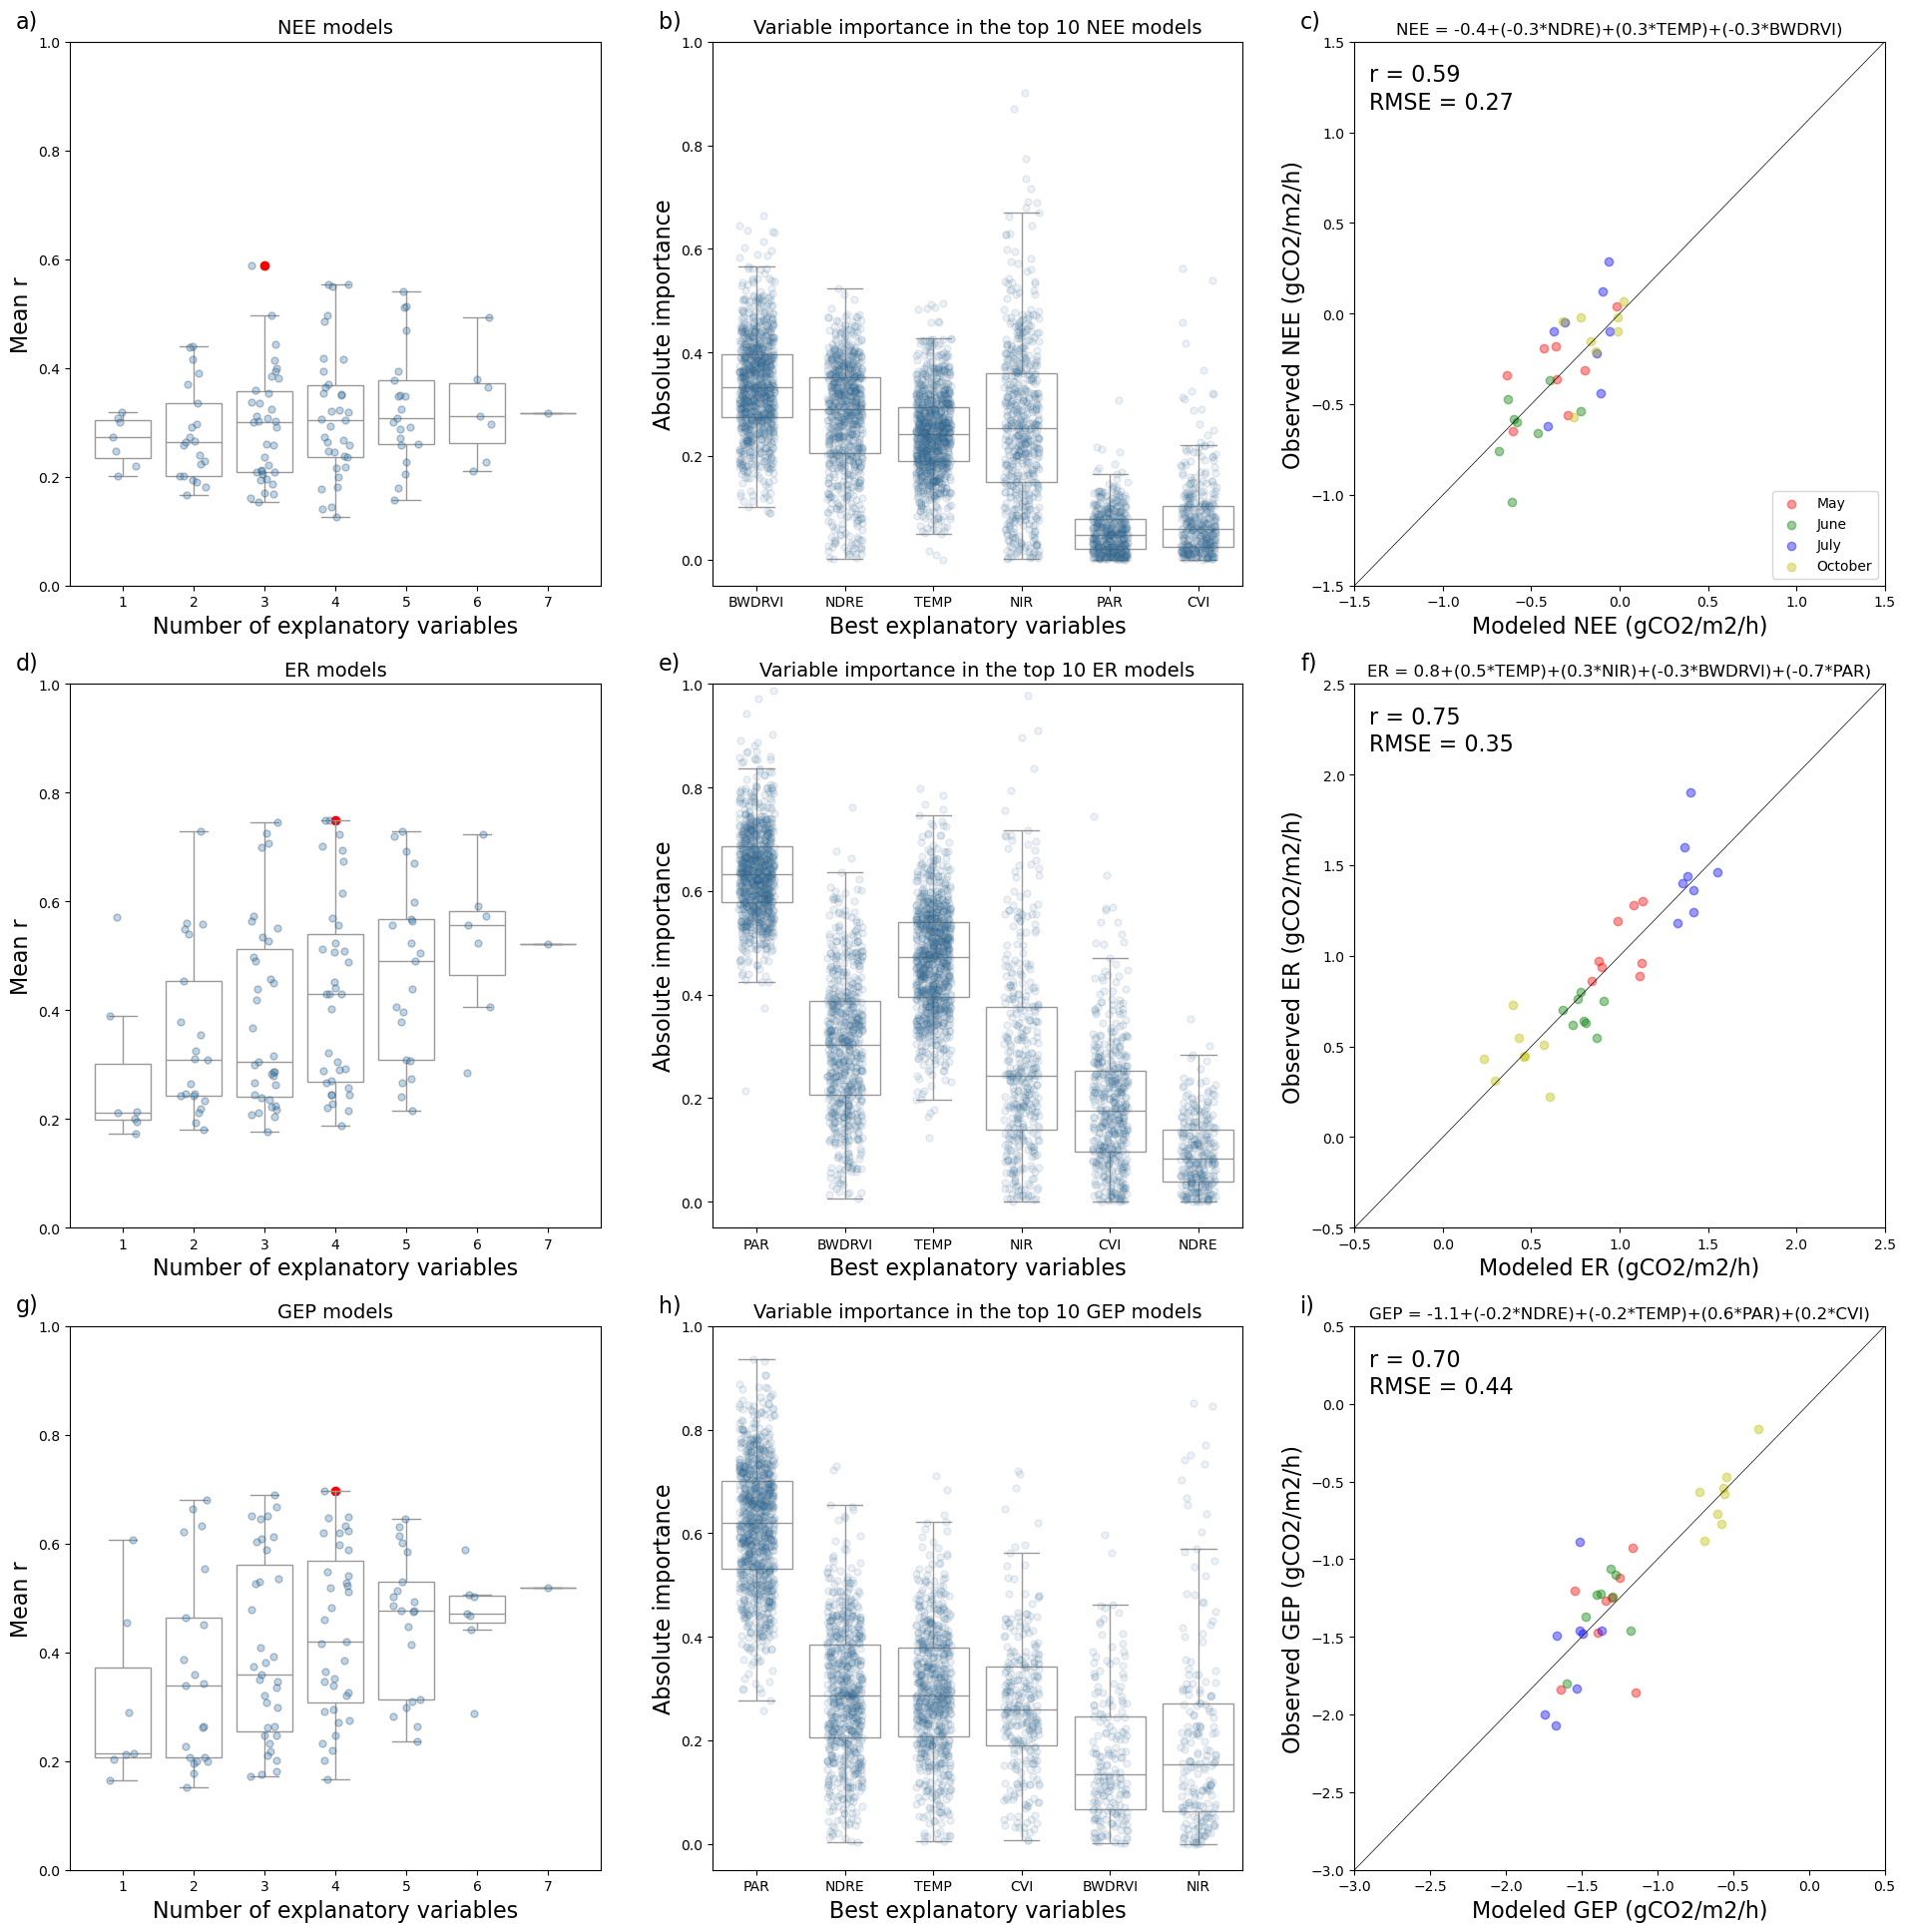

In [17]:
# Display the figure
fig, ((ax1, ax2, ax7), (ax3, ax4, ax8), (ax5, ax6, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
fig.tight_layout(pad=5)

ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
ax1.text(-0.05, 1.0, 'a)', transform=ax1.transAxes + trans, fontsize = 16, va='bottom')
df = UAV_NEE_BestModels[['NbOfExpVar','Mean R']]
sns.stripplot(x='NbOfExpVar', y='Mean R', data=df, jitter=0.2, alpha=1/3, linewidth=1, color = '#2986cc', ax = ax1)
sns.boxplot(x='NbOfExpVar', y='Mean R',data=df,linewidth=1,color='white',showfliers=False, ax= ax1)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6], ['1', '2', '3', '4', '5', '6', '7'])
ax1.scatter(2, UAV_NEEMeanR, c='r')
ax1.set_ylabel("Mean r",fontsize = 16)
ax1.set_ylim([0, 1])
ax1.set_xlabel("Number of explanatory variables",fontsize = 16)
ax1.set_title('NEE models',fontsize = 14)

df = dfnee.stack().reset_index(level=-1,drop=False).rename(columns={'level_1': 'Feature', 0: 'Importance'}) # this drops NaNs
sns.stripplot(x='Feature', y='Importance', data=df, jitter=0.2, alpha=0.1, linewidth=1, color = '#2986cc', ax = ax2)
sns.boxplot(x='Feature', y='Importance',data=df,color='white',showfliers=False, ax= ax2)
ax2.set_ylim([-0.05, 1])
ax2.set_xlabel("Best explanatory variables", fontweight='normal', fontsize=16)
ax2.set_ylabel("Absolute importance", fontweight='normal', fontsize=16)
ax2.text(-0.05, 1.0, 'b)', transform=ax2.transAxes + trans, fontsize = 16, va='bottom')
ax2.set_title('Variable importance in the top 10 NEE models',fontsize = 14)

ax7.scatter(UAV_NEE_MAY_MODELED, UAV_NEE_MAY_OBSERVED, label='May', color='r', alpha=0.4)
ax7.scatter(UAV_NEE_JUNE_MODELED, UAV_NEE_JUNE_OBSERVED, label='June',color='g', alpha=0.4)
ax7.scatter(UAV_NEE_JULY_MODELED, UAV_NEE_JULY_OBSERVED, label='July',color='b', alpha=0.4)
ax7.scatter(UAV_NEE_OCTOBER_MODELED, UAV_NEE_OCTOBER_OBSERVED, label='October',color='y', alpha=0.4)
ax7.set_ylim([-1.5, 1.5])
ax7.set_xlim([-1.5, 1.5])
ax7.set_ylabel("Observed NEE (gCO2/m2/h)", fontweight='normal', fontsize=16)
ax7.set_xlabel("Modeled NEE (gCO2/m2/h)", fontweight='normal', fontsize=16)
ax7.text(-0.05, 1.0, 'c)', transform=ax7.transAxes + trans, fontsize = 16, va='bottom')
ax7.axline((0, 0), (1, 1), linewidth=0.5, color='k')
ax7.legend(loc='lower right')
ax7.text(0.08, 0.90, UAV_NEE_model_R, transform=ax7.transAxes + trans, fontsize = 16, va='bottom')
ax7.text(0.08, 0.85, UAV_NEE_model_RMSE, transform=ax7.transAxes + trans, fontsize = 16, va='bottom')
ax7.set_title(UAV_NEE_model_formula,fontsize = 12)

ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
ax3.text(-0.05, 1.0, 'd)', transform=ax3.transAxes + trans, fontsize = 16, va='bottom')
df = UAV_ER_BestModels[['NbOfExpVar','Mean R']]
sns.stripplot(x='NbOfExpVar', y='Mean R', data=df, jitter=0.2, alpha=1/3, linewidth=1, color = '#2986cc', ax = ax3)
sns.boxplot(x='NbOfExpVar', y='Mean R',data=df,linewidth=1,color='white',showfliers=False, ax= ax3)
ax3.scatter(3, UAV_ERMeanR, c='r')
ax3.set_xticks([0, 1, 2, 3, 4, 5, 6], ['1', '2', '3', '4', '5', '6', '7'])
ax3.set_ylabel("Mean r",fontsize = 16)
ax3.set_ylim([0, 1])
ax3.set_xlabel("Number of explanatory variables",fontsize = 16)
ax3.set_title('ER models',fontsize = 14)

df = dfer.stack().reset_index(level=-1,drop=False).rename(columns={'level_1': 'Feature', 0: 'Importance'}) # this drops NaNs
sns.stripplot(x='Feature', y='Importance', data=df, jitter=0.2, alpha=0.1, linewidth=1, color = '#2986cc', ax = ax4)
sns.boxplot(x='Feature', y='Importance',data=df,color='white',showfliers=False, ax= ax4)
ax4.set_ylim([-0.05, 1])
ax4.set_ylabel("Absolute importance", fontweight='normal', fontsize=16)
ax4.set_xlabel("Best explanatory variables", fontweight='normal', fontsize=16)
ax4.text(-0.05, 1.0, 'e)', transform=ax4.transAxes + trans, fontsize = 16, va='bottom')
ax4.set_title('Variable importance in the top 10 ER models',fontsize = 14)

ax8.scatter(UAV_ER_MAY_MODELED, UAV_ER_MAY_OBSERVED, label='May', color='r', alpha=0.4)
ax8.scatter(UAV_ER_JUNE_MODELED, UAV_ER_JUNE_OBSERVED, label='June',color='g', alpha=0.4)
ax8.scatter(UAV_ER_JULY_MODELED, UAV_ER_JULY_OBSERVED, label='July',color='b', alpha=0.4)
ax8.scatter(UAV_ER_OCTOBER_MODELED, UAV_ER_OCTOBER_OBSERVED, label='October',color='y', alpha=0.4)
ax8.set_ylim([-0.5, 2.5])
ax8.set_xlim([-0.5, 2.5])
ax8.set_ylabel("Observed ER (gCO2/m2/h)", fontweight='normal', fontsize=16)
ax8.set_xlabel("Modeled ER (gCO2/m2/h)", fontweight='normal', fontsize=16)
ax8.text(-0.05, 1.0, 'f)', transform=ax8.transAxes + trans, fontsize = 16, va='bottom')
ax8.axline((0, 0), (1, 1), linewidth=0.5, color='k')
ax8.text(0.08, 0.90, UAV_ER_model_R, transform=ax8.transAxes + trans, fontsize = 16, va='bottom')
ax8.text(0.08, 0.85, UAV_ER_model_RMSE, transform=ax8.transAxes + trans, fontsize = 16, va='bottom')
ax8.set_title(UAV_ER_model_formula,fontsize = 12)

ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax5.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
ax5.text(-0.05, 1.0, 'g)', transform=ax5.transAxes + trans, fontsize = 16, va='bottom')
df = UAV_GEP_BestModels[['NbOfExpVar','Mean R']]
sns.stripplot(x='NbOfExpVar', y='Mean R', data=df, jitter=0.2, alpha=1/3, linewidth=1, color = '#2986cc', ax = ax5)
sns.boxplot(x='NbOfExpVar', y='Mean R',data=df,linewidth=1,color='white',showfliers=False, ax= ax5)
ax5.scatter(3, UAV_GEPMeanR, c='r')
ax5.set_xticks([0, 1, 2, 3, 4, 5, 6], ['1', '2', '3', '4', '5', '6', '7'])
ax5.set_ylabel("Mean r",fontsize = 16)
ax5.set_ylim([0, 1])
ax5.set_xlabel("Number of explanatory variables",fontsize = 16)
ax5.set_title('GEP models',fontsize = 14)

df = dfgep.stack().reset_index(level=-1,drop=False).rename(columns={'level_1': 'Feature', 0: 'Importance'}) # this drops NaNs
sns.stripplot(x='Feature', y='Importance', data=df, jitter=0.2, alpha=0.1, linewidth=1, color = '#2986cc', ax = ax6)
sns.boxplot(x='Feature', y='Importance',data=df,color='white',showfliers=False, ax= ax6)
ax6.set_ylim([-0.05, 1])
ax6.set_ylabel("Absolute importance", fontweight='normal', fontsize=16)
ax6.text(-0.05, 1.0, 'h)', transform=ax6.transAxes + trans, fontsize = 16, va='bottom')
ax6.set_xlabel("Best explanatory variables", fontweight='normal', fontsize=16)
ax6.set_title('Variable importance in the top 10 GEP models',fontsize = 14)

ax9.scatter(UAV_GEP_MAY_MODELED, UAV_GEP_MAY_OBSERVED, label='May', color='r', alpha=0.4)
ax9.scatter(UAV_GEP_JUNE_MODELED, UAV_GEP_JUNE_OBSERVED, label='June',color='g', alpha=0.4)
ax9.scatter(UAV_GEP_JULY_MODELED, UAV_GEP_JULY_OBSERVED, label='July',color='b', alpha=0.4)
ax9.scatter(UAV_GEP_OCTOBER_MODELED, UAV_GEP_OCTOBER_OBSERVED, label='October',color='y', alpha=0.4)
ax9.set_ylim([-3, 0.5])
ax9.set_xlim([-3, 0.5])
ax9.set_ylabel("Observed GEP (gCO2/m2/h)", fontweight='normal', fontsize=16)
ax9.set_xlabel("Modeled GEP (gCO2/m2/h)", fontweight='normal', fontsize=16)
ax9.text(-0.05, 1.0, 'i)', transform=ax9.transAxes + trans, fontsize = 16, va='bottom')
ax9.axline((0, 0), (1, 1), linewidth=0.5, color='k')
ax9.text(0.08, 0.90, UAV_GEP_model_R, transform=ax9.transAxes + trans, fontsize = 16, va='bottom')
ax9.text(0.08, 0.85, UAV_GEP_model_RMSE, transform=ax9.transAxes + trans, fontsize = 16, va='bottom')
ax9.set_title(UAV_GEP_model_formula,fontsize = 12)


plt.savefig("F:/Redaction/Bernadouze/Figures/NewFigure8.tif", dpi = 600)  
plt.show()